In [488]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [489]:
import random
import numpy as np
import random
import gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from IPython.display import clear_output
import time
from tqdm import tqdm

### Setting Up the Environment


In [490]:
#Setting up the environment
env = gym.make("Taxi-v3")
env.reset()

#Current state
print(env.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", env.observation_space.n)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
print("Primitive actions: ", action)
print("Options: ", ["OptionR", "OptionG", "OptionY", "OptionB"])
print("Total actions: ", action + ["OptionR", "OptionG", "OptionY", "OptionB"])

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.action_space.n)


# env.render()

94
Number of states: 500
Primitive actions:  ['south', 'north', 'east', 'west', 'pick', 'drop']
Options:  ['OptionR', 'OptionG', 'OptionY', 'OptionB']
Total actions:  ['south', 'north', 'east', 'west', 'pick', 'drop', 'OptionR', 'OptionG', 'OptionY', 'OptionB']
Number of actions that an agent can take: 6


#### Epsilon Greedy

In [491]:
def epgreedy_policy(q_values, state, epsilon):
    if q_values[state].any() and random.random() > epsilon:
        return np.argmax(q_values[state])
    
    else:
        return random.randint(0, q_values.shape[-1]-1)

In [492]:
#Number of options
num_options = 4

#Goal States' Coordinates
GOAL_STATES_OPTIONS = {0: [2,0], 1: [2,4]}

GOAL_STATES = {0: [0,0], 1: [0,4],2:[4,0],3:[4,3]}

### SMDP Q-Learning Definition

In [540]:
ALPHA = 0.03
GAMMA = 0.9
EPS_MIN = 0.01
EPS_DECAY = 0.99
eps_main = 0.5
eps_options = {i:0.01 for i in range(4)}

NUM_X = 5
NUM_Y = 5
NUM_PAS_LOCS = 5
NUM_DROP_LOCS = 4

NUM_EPISODES = 1500

num_goals=4

#Q-Table and Update-Frequencies
q_values_SMDP = np.zeros([NUM_PAS_LOCS*NUM_DROP_LOCS, num_options])
update_freq_SMDP = np.zeros([NUM_PAS_LOCS*NUM_DROP_LOCS, num_goals])

#Q-values for each option

QgoalSMDP = {i:np.zeros((env.observation_space.n//20, env.action_space.n-2)) for i in range(num_goals)}


### Options Definition - NavigatePickup, NavigateDrop

In [495]:
class OptionSelection:
    def __init__(self,env,eps=0.1):
        self.env=env
        self.eps=eps
    
    #Option for Pickup
    def NavigateOptionPickup(self,state,Q,goalNum,eps=0.1):
        
        optdonePickup = False
        x, y, pas_loc, drop_loc = self.env.decode(state)

        #If pickup not done
        if pas_loc<4:

            # Check if the passenger is at the destination
            if (x == GOAL_STATES[goalNum][0] and y == GOAL_STATES[goalNum][1]):
                optact = 4  # Indicates the drop action
                optdonePickup = True
 
            else:
                state_num = 5*x + y
                optact = epgreedy_policy(Q[pas_loc],  state_num, epsilon= eps)
            return [optact, optdonePickup]
        
    #Option for Drop
    def NavigateOptionDrop(self,state,Q,goalNum,eps=0.1):
    
        optdoneDrop = False
        x, y, pas_loc, drop_loc = self.env.decode(state)

        if pas_loc==4:

            # Check if the passenger is at the destination
            if (x == GOAL_STATES[goalNum][0] and y == GOAL_STATES[goalNum][1]):
                optact = 5  # Indicates the drop action
                optdoneDrop = True

            else:
                state_num = 5*x + y
                optact = epgreedy_policy(Q[drop_loc], state_num, epsilon= eps)

            return [optact, optdoneDrop]
    
    #Select Options Sequentially
    def Options(self, state, Q,goalNum, eps=0.1):
        x, y, pas_loc, drop_loc = self.env.decode(state)

        #Pickup option if pickup not done
        if pas_loc < 4:
            return self.NavigateOptionPickup(state, Q,goalNum, eps=eps)
        
        #Drop option if pickup done
        elif pas_loc == 4:
            return self.NavigateOptionDrop(state, Q,goalNum, eps=eps)

### SMDP Q-Learning Definition

In [541]:
def smdpQlearning(env, num_episodes = NUM_EPISODES, gamma = GAMMA, alpha = ALPHA, eps_main = eps_main,eps_options = eps_options):
    total_episodic_rewards_smdp = []
    count = 0
    eps_main2 = 0.5
    for i in tqdm(range(num_episodes)):
        # state = env.reset()[0]
        state=env.reset()
        done = False
        total_reward = 0
        T=1
        SelectedOption=OptionSelection(env,eps_main)

        
        while not done:

            #choose action
            x,y,pas_loc, drop_loc = env.decode(state)

            subState = NUM_DROP_LOCS*pas_loc + drop_loc

            x, y, pas_loc, drop_loc = env.decode(state)

            option = epgreedy_policy(q_values_SMDP, subState, epsilon=eps_main2)
            eps_main2 = max(EPS_MIN,EPS_DECAY*eps_main2)

            reward_bar = 0
            optdone = False
            move = 0
            starting_state = state

            while not optdone and not done:

                optact, optdone = SelectedOption.Options(state, QgoalSMDP,option, eps=eps_options[option])
                eps_options[option] = max(EPS_MIN, EPS_DECAY*eps_options[option])

                x,y,_,_ = env.decode(state); state_num = 5*x + y
                next_state, reward, done, _ = env.step(optact)

                #Render for last episode
                if i == num_episodes-1:
                    clear_output(wait=True)
                    print(env.render())  
                    time.sleep(T)
                x_next, y_next,_,_ = env.decode(next_state); next_state_num = 5*x_next + y_next

                reward_bar = gamma*reward + reward
                move +=1
                total_reward += reward
                reward_surr = reward

                if optdone:
                    reward_surr = 20
                if optact <4:
                    #Update Q-values for primitive actions in each option
                    QgoalSMDP[option][state_num, optact] += alpha*(reward_surr + gamma*np.max(QgoalSMDP[option][next_state_num]) - QgoalSMDP[option][state_num, optact])

                state = next_state

            _,_,pas_loc, drop_loc = env.decode(state)
            subState = NUM_DROP_LOCS*pas_loc + drop_loc

            _,_,pas_loc, drop_loc = env.decode(starting_state)
            subStartState = NUM_DROP_LOCS*pas_loc + drop_loc

            q_values_SMDP[subStartState, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState,:]) - q_values_SMDP[subStartState, option])
            
            #Update frequency
            update_freq_SMDP[subStartState, option] +=1


        total_episodic_rewards_smdp.append(total_reward)
        x,y,pas_loc, drop_loc = env.decode(state)

        
        if pas_loc == drop_loc:
            count +=1
            clear_output(wait=True)
            
            print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

    return total_episodic_rewards_smdp

In [542]:
episodic_rewards_SMDP = smdpQlearning(env)

100%|██████████| 1500/1500 [00:25<00:00, 59.23it/s] 

Success (1282/1500) = 85.46666666666667%


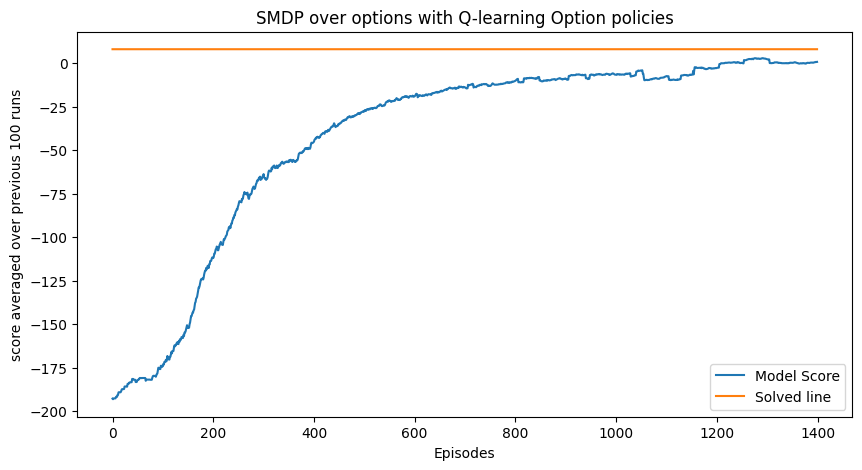

In [543]:
plt.figure(figsize = (10,5))
avg_rews2 = [np.average(episodic_rewards_SMDP[i:i+100]) for i in range(len(episodic_rewards_SMDP)-100)]
plt.plot(avg_rews2,label = 'Model Score')
plt.plot([8 for i in range(len(avg_rews2))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP over options with Q-learning Option policies')
plt.legend()

### Intra-Options Q-Learning

In [550]:

ALPHA = 0.99
GAMMA = 0.9
EPS_MIN = 0.01
EPS_DECAY = 0.99
eps_main = 0.5
eps_options = {i:0.01 for i in range(4)}

#Q-Table and Update-Frequencies
q_values_IOQL = np.zeros([NUM_PAS_LOCS*NUM_DROP_LOCS, num_options])

update_freq_IOQL = np.zeros([NUM_PAS_LOCS*NUM_DROP_LOCS, num_goals])
QgoalIOQL = {i:np.zeros((env.observation_space.n//20, env.action_space.n-2)) for i in range(num_goals)}

In [500]:
def ReturnSubstate(state, nPas = NUM_PAS_LOCS, nDrop = NUM_DROP_LOCS):
  _,_,pas,drop = env.decode(state) 
  subState = nDrop*pas+drop 
  return subState 

In [551]:

def IntraOpt(env, num_episodes = NUM_EPISODES, gamma = GAMMA, alpha = ALPHA, eps_main = eps_main,eps_options = eps_options):
  eps_main2=0.5

  total_episodic_rewards_ioql = []
  count=0
  T=1
  # Iterate over Number of Episodes
  for i in tqdm(range(NUM_EPISODES)):
      state = env.reset()    
      done = False
      tot_rew=0
      SelectedOption=OptionSelection(env,eps_main)
      # While episode is not over
      while not done:

          x, y, pas_loc, drop_loc = env.decode(state)

          subState = NUM_DROP_LOCS*pas_loc+drop_loc   
          
          option = epgreedy_policy(q_values_IOQL, subState, epsilon=eps_main2)
          eps_main2 = max(EPS_MIN,EPS_DECAY*eps_main2)

          optdone = False
          prev = state  

          while not optdone and not done:
              
              optact,optdone = SelectedOption.Options(state,QgoalIOQL,option, eps_options[option])
              eps_options[option] = max(EPS_MIN,EPS_DECAY*eps_options[option])
              next_state, reward, done,_ = env.step(optact)
              tot_rew+=reward

              [x,y,_,_]=  list(env.decode(state)) 
              [x1,y1,_,_]=  list(env.decode(next_state)) 

              reward_surr = reward
              
              if optact<4:  
                QgoalIOQL[option][5*x+y, optact] = QgoalIOQL[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(QgoalIOQL[option][5*x1+y1, :]) - QgoalIOQL[option][5*x+y, optact])

              #finding all options giving same action call
              for same_action_options in range(num_options):
                optact_o,optdone_o = SelectedOption.Options(state,QgoalIOQL,same_action_options, eps_options[same_action_options])
                if optact_o == optact:
                  eps_options[same_action_options] = max(EPS_MIN,EPS_DECAY*eps_options[same_action_options])
                  if optdone_o:
                    q_values_IOQL[ReturnSubstate(state), same_action_options] += alpha*(reward + gamma*np.max(q_values_IOQL[ReturnSubstate(next_state), :]) - q_values_IOQL[ReturnSubstate(state), same_action_options])

                  else:
                    q_values_IOQL[ReturnSubstate(state), same_action_options] += alpha*(reward + gamma*q_values_IOQL[ReturnSubstate(next_state), same_action_options] - q_values_IOQL[ReturnSubstate(state), same_action_options]) 

                  update_freq_IOQL[ReturnSubstate(state), same_action_options] += 1
              
              state = next_state 
              if i==NUM_EPISODES-1:
                  clear_output(wait=True)
                  print(env.render())
                  time.sleep(T)

      total_episodic_rewards_ioql.append(tot_rew)
      x,y,pas,drop = env.decode(state)
      if pas==drop:
        count+=1
        clear_output(wait=True)
        print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

  return total_episodic_rewards_ioql
      

In [552]:
episodic_rewards_IOQL = IntraOpt(env)

100%|██████████| 1500/1500 [00:19<00:00, 76.29it/s] 

Success (1331/1500) = 88.73333333333333%


IOQL Rewards

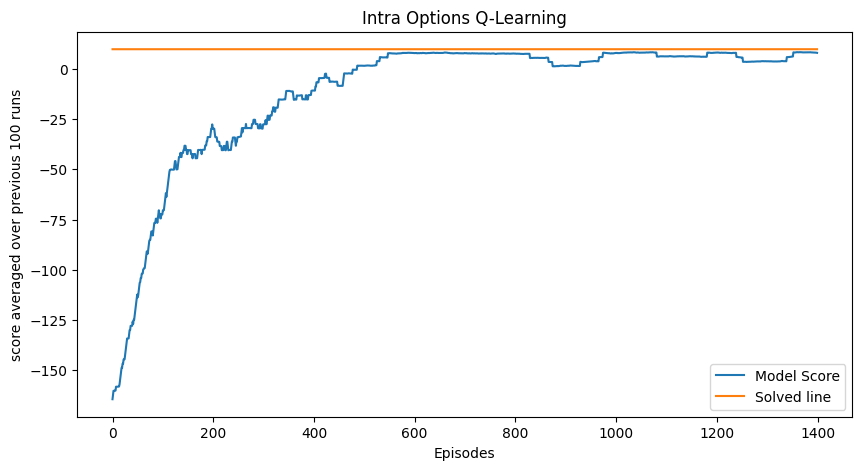

In [553]:
plt.figure(figsize = (10,5))
avg_rews2 = [np.average(episodic_rewards_IOQL[i:i+100]) for i in range(len(episodic_rewards_IOQL)-100)]
plt.plot(avg_rews2,label = 'Model Score')
plt.plot([9.7 for i in range(len(avg_rews2))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Intra Options Q-Learning')
plt.legend()

#### Plot comparing the reward curves

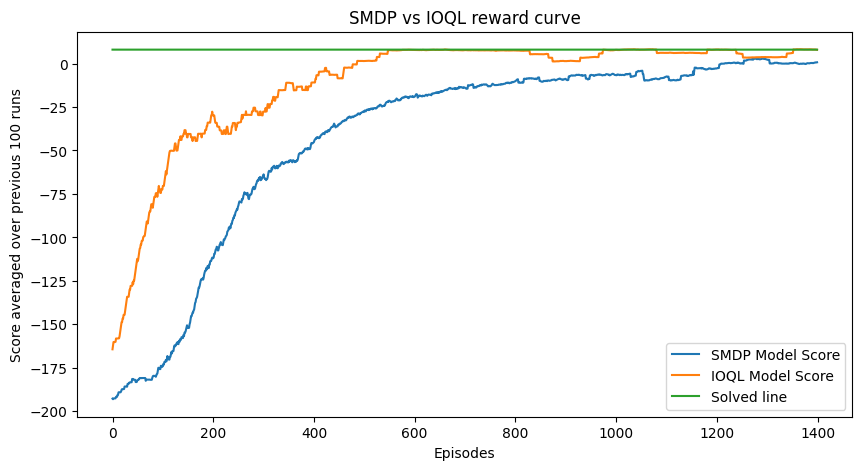

In [554]:
import matplotlib.pyplot as plt

# Assuming episodic_rewards_SMDP and episodic_rewards_IOQL are lists containing episodic rewards for SMDP and IOQL respectively

plt.figure(figsize=(10, 5))

# Calculate average rewards over a window of 100 episodes for both SMDP and IOQL
avg_rews_SMDP = [np.average(episodic_rewards_SMDP[i:i+100]) for i in range(len(episodic_rewards_SMDP)-100)]
avg_rews_IOQL = [np.average(episodic_rewards_IOQL[i:i+100]) for i in range(len(episodic_rewards_IOQL)-100)]

# Plot average rewards
plt.plot(avg_rews_SMDP, label='SMDP Model Score')
plt.plot(avg_rews_IOQL, label='IOQL Model Score')
solved_score = env.spec.reward_threshold
plt.plot([solved_score for _ in range(len(avg_rews_SMDP))], label='Solved line')

plt.xlabel('Episodes')
plt.ylabel('Score averaged over previous 100 runs')
plt.title('SMDP vs IOQL reward curve')
plt.legend()

plt.show()


#### Plot comparing the moving avg reward (window-size = 100 episodes) curves for first 300 episodes

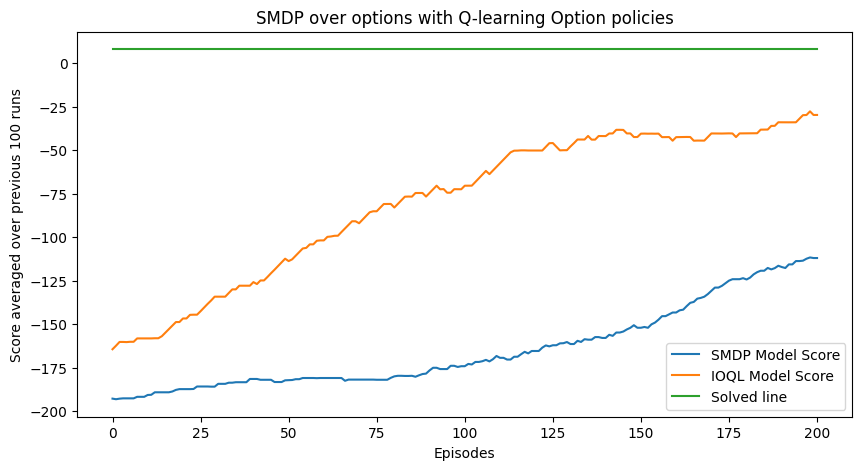

In [555]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Calculate average rewards over a window of 100 episodes for both SMDP and IOQL
avg_rews_SMDP = [np.average(episodic_rewards_SMDP[i:i+100]) for i in range(300+1-100)]
avg_rews_IOQL = [np.average(episodic_rewards_IOQL[i:i+100]) for i in range(300+1-100)]

# Plot average rewards
plt.plot(avg_rews_SMDP, label='SMDP Model Score')
plt.plot(avg_rews_IOQL, label='IOQL Model Score')
solved_score = env.spec.reward_threshold
plt.plot([solved_score for _ in range(len(avg_rews_SMDP))], label='Solved line')

plt.xlabel('Episodes')
plt.ylabel('Score averaged over previous 100 runs')
plt.title('SMDP over options with Q-learning Option policies')
plt.legend()

plt.show()
